In [1]:
%matplotlib inline
import io, os, sys, types

# this import imports the databaseloader script (which only does TGSS and VLSSR for now)
import Databaseloader as dl

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tkp.db
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog
from tkp.db.model import Newsource
from tkp.db.model import Extractedsource
from tkp.db.model import Image
from operator import itemgetter, attrgetter
import logging
from pandas import DataFrame
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
#import Tools
#import generic_tools
#import plotting_tools
from scipy.stats import norm
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
#from astroML import density_estimation

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance

logging.basicConfig(level=logging.INFO)

In [2]:
engine = 'postgresql'
host = 'vlo.science.uva.nl'
port = 5432
user = 'kmeulen'
password = 'kLu2oepRouv2UfoUPhoU'
database='KmeulenTrap4P23'
websiteURL = 'http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
latexURL = '\url{http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

In [3]:
# this is sqlalchemy script to login to the Banana database
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=database)
db.connect()
session = db.Session()

# Here i get the peak flux and the error on the peak flux from all the sources in the database
fpeak = session.query(Extractedsource.f_peak).all()
fpeake = session.query(Extractedsource.f_peak_err).all()
califreq = np.load("freqlist.npy")
califlux = np.load("fluxlist.npy")

INFO:tkp.db.database:Database config: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenTrap4P23
/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenTrap4P23


Query to find the variability parameters of the sources in a specific dataset 

In [4]:
# Here I specifiy which dataset of the database to use
dataset_id = 4

VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()



Make 2d array of all the sources except for the transients.

In [5]:

plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Runningcatalog.wm_ra,\
             VarParams[i].Runningcatalog.wm_decl,VarParams[i].Runningcatalog.avg_ra_err,\
             VarParams[i].Runningcatalog.avg_decl_err, VarParams[i].Runningcatalog.datapoints,\
             session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().newsource_type,\
             VarParams[i].Varmetric.newsource,VarParams[i].Varmetric.lightcurve_max, session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().trigger_xtrsrc.id]\
            for i in range(len(VarParams)) if VarParams[i].Varmetric.newsource != None]


In [422]:
# The de Ruiter distance as shown in the Trap Paper section 4.4 https://arxiv.org/abs/1503.01526 

def CalcDeRuiter(transient,ra2,ra2e,dec2,dec2e):
    ra1 = transient['ra']
    dec1 = transient['dec']
    ra1e = transient['rae']
    dec1e = transient['dece']

    r=(np.sqrt((((-1*ra2 +ra1)**2)*(np.cos((dec1+dec2)/2))**2)/\
                       (ra1e**2+ra2e**2)+((-1*dec2+dec1)**2/(dec1e**2+dec2e**2))))
    return r 

In [423]:
# Comparing the fluxes heavily inspired on the de Ruiter distance as used by Bart's thesis: https://api-alumni.nl/media/uploads/theses/phd/lha-scheers-phd.pdf page 55

def CompareFluxes(transient,pflux2,pflux2e,scale=1):
    pflux1 = transient['pflux']*scale
    pflux1e = transient['pfluxe']*scale
    
    r = np.sqrt((((-1*pflux2 +pflux1)**2))/\
                       (pflux1e**2+pflux2e**2))
    return r

In [424]:
# calculates the frequency flux scale based on supplied califreq and califlux data

def CalcFreqScale(transient,datafreq,califreq,califlux):
    """Function for calculating the frequency scale"""
    transfreq = transient.freq
    for i in range(len(califreq)):
        if transfreq - 0.005 <= califreq[i] <= transfreq + 0.005:
            oldflux = califlux[i]
        if datafreq - 0.005 <= califreq[i] <= datafreq + 0.005:
            newflux = califlux[i]
    scale = newflux/oldflux
    return scale

Function for pruning our candidate list

In [425]:
def SelectorForCandidates(rcheck,ycheck,checklight,deruiter=True):
    """Function for pruning the candidate list using both distance and lightcurve measurements"""
    
    print 'before:'
    print len(Transients.instances)
    oldlen = len(Transients.instances) + 1
    
# #   Repeat until no improvement in the length of the candidate list
    while len(Transients.instances) - oldlen < 0:

        translist = []
#         rlist = []
        oldlen = len(Transients.instances)
        
#         These lists are necessary to compare the candidate transients against each other
        ralist = []
        raelist = []
        declist = []
        decelist = []
        pfluxlist = []
        pfluxelist = []

    # """Check candidate transients against each other"""
    
    
        for i in Transients.instances:
            if not deruiter:
                translist.append(i.radec)
            else:
                ralist.append(i.ra)
                raelist.append(i.rae)
                declist.append(i.dec)
                decelist.append(i.dece)
                pfluxlist.append(i.pflux)
                pfluxelist.append(i.pfluxe)

                
        
#       if we are not using deruiter distance use euclidean (it is slightly outdated and not used alot
#       I would recommend just using the deruiterdistance method which also features the updated fluxcheckmethod)
        if not deruiter:
            index1list = []
            index2list = []
            translist = np.reshape(translist,(len(Transients.instances),2))
            Z = distance.cdist(translist,translist,'euclidean')

        # select on distance measure of 0.06 difference
            for g in range(len(Z)):
                for j in range(len(Z[g])):
                    if Z[g][j] <=0.06 and Z[g][j] !=0.0:
                        index1list.append(g)
                        index2list.append(j)
                    i = 0
                    
# the deletion process for notderuiterdistance                    
            while i < len(index1list):

                if checklight:


                    try:
                        if  Transients.instances[index2list[i]].pflux*0.8 <= Transients.instances[index1list[i]].pflux <= Transients.instances[index2list[i]].pflux*1.2:
                            index1list.remove(index2list[i])
                            Transients.instances[index1list[i]] = []
                    except:
                        pass

                else:
                    index1list.remove(index2list[i])
                    Transients.instances[index1list[i]] = []


                i+=1

            i = 0
            while i < len(Transients.instances):
                if Transients.instances[i]:
                    pass
                else:
                    del Transients.instances[i]
                    i-=1     
                i+=1
                        
                        
#       "here we are using deRuiter to calculate the fluxes

        else:
            h = 0
            while h <(len(Transients.instances)):
#               calculate both the deruiterdistance's and compare the fluxes.
                r = CalcDeRuiter(vars(Transients.instances[h]),np.array(ralist),\
                                 np.array(raelist),np.array(declist),np.array(decelist))
                if checklight:
                    y = CompareFluxes(vars(Transients.instances[h]),np.array(pfluxlist),np.array(pfluxelist))
                jk = 0
                for j in range(len(r)):
                    if jk >= len(Transients.instances):
                        break
                    if checklight:
                        if r[j] <=rcheck and r[j]!= 0.0 and 0 < y[j] <=ycheck:
                            del Transients.instances[h]
                            h-=1
                            jk=0
                            break
                    else:
                        if r[j] <=rcheck and r[j]!= 0.0:
                            del Transients.instances[h]
                            h-=1
                            jk=0
                            break
                    jk+=1
                   
                h+=1

        


    # """Check Candidates against all sources"""
#     a zero candidate that is being tracked if the flux is comparable to the transient 
#     could be real things when it is consistently brighter or fainter than the candidate 1.
#  Talk to Mark about pyc to get flux at specific coordinate ore look at the options. in the pyc-h 

        masterindex = []
        ilist = []
        for i in Transients.instances:
            indexlist = []
            
#             again the outdated euclidean method
            if not deruiter:
                Y = distance.cdist(i.radec,X,'euclidean')

                for g in Y:
                    for j in range(len(g)):
                        if checklight:
                            if g[j] <=0.06 and 0.8*lightcata[j]<=i.pflux <= 1.2*lightcata[j]:
                                indexlist.append(j)
                        else:
                            if g[j] <=0.06:
                                indexlist.append(j)
                
#             the de Ruiter method 
            else:
                r = CalcDeRuiter(vars(i),np.array(racata),np.array(raecata),np.array(deccata),np.array(dececata))
                y = CompareFluxes(vars(i),np.array(lightcata),np.array(lightecata))
                for j in range(len(r)):
                    if checklight:
                        if r[j] <=rcheck and y[j]<=ycheck:
                            indexlist.append(j)
                                
                            
                            
                    else:
                        if r[j] <=rcheck:
                            indexlist.append(j)
            masterindex.append(indexlist)
            
# removing the fake candidates
        i = 0
        j= 0
        while i < len(masterindex):
            if masterindex[i]:
                del Transients.instances[j]
                j-=1
            i+=1
            j+=1

    print 'after:'    
    print len(Transients.instances)



Function for comparing transient candidate against external databases

In [426]:

def CheckOutsideDatabase(data,rcheck,ycheck,checklight,gamma,deruiter = True):
    """ Function for checking against outside database the data entry is for the database rcheck is condition \
where we check deruiter against, ycheck is where we check de flux against and checklight,gamma,deruiter\
are booleans which switch on checking the flux(checklight), checking using error on the flux(gamma) and \
using deruiter distance

"""
    scale =  CalcFreqScale(Transients.instances[0],data.freq,califreq,califlux)
    masterindex = []
    savedilist = []
    print 'before:'

    print len(Transients.instances)

    for i in Transients.instances:
        indexlist = []

        if not deruiter:
            Y = distance.cdist(i.radec,data.radec,'euclidean')
            if gamma:
                y = CompareFluxes(vars(i),np.array(data.pflux),np.array(data.pfluxe),scale)
                
                for g in Y:

                    for j in range(len(g)):

                        if g[j] <=0.06 and y[j]>= ycheck:
                            if i.id not in savedilist:
                                FluxVar(vars(i),j,data,scale)
                                savedilist.append(i.id)
                            indexlist.append(j)

                        elif g[j] <=0.06:
                            indexlist.append(j)
                    
            else:
                for g in Y:

                    for j in range(len(g)):
                        if checklight:

                            if g[j] <=0.06 and (i.pflux*scale <= 0.9*data.pflux[j] or i.pflux*scale>=1.1*data.pflux[j]):
                                if i.id not in savedilist:
                                    FluxVar(vars(i),j,data,scale)
                                    savedilist.append(i.id)
                                indexlist.append(j)

                            elif g[j] <=0.06:
                                indexlist.append(j)
                        else:
                            if g[j] <=0.06:
                                indexlist.append(j)

        else:

            r = CalcDeRuiter(vars(i),np.array(data.ra),np.array(data.rae),np.array(data.dec),np.array(data.dece))
            if gamma:
                y = CompareFluxes(vars(i),np.array(data.pflux),np.array(data.pfluxe),scale)

                for j in range(len(r)):

                    if r[j] <=rcheck and y[j]>= ycheck:
                        indexlist.append(j)
                        if i.id not in savedilist:
                            FluxVar(vars(i),j,data,scale)
                            savedilist.append(i.id)

                    elif r[j] <=rcheck:
                        indexlist.append(j)

            else:
                for j in range(len(r)):
                    if checklight:
                        if r[j] <=rcheck and (i.pflux*scale <= 0.9*data.pflux[j] or i.pflux*scale>=1.1*data.pflux[j]):
                            indexlist.append(j)
                            if i.id not in savedilist:
                                FluxVar(vars(i),j,data,scale)
                                savedilist.append(i.id)
                        elif r[j] <=rcheck:
                            indexlist.append(j)





                    else:
                        if r[j] <=rcheck:
                            indexlist.append(j)

        masterindex.append(indexlist)
    
        
    i = 0
    while i < len(masterindex):
        if not masterindex[i]:
            PosVar(vars(Transients.instances[i]),data)
        i+=1

    print 'after:'  
    print str(len(PosVar.instances)) +" Interesting candidates"
    print str(len(FluxVar.instances)) + " Flux Varying candidates"


Class object for saving our candidate transients, class object for storing objects that have varying flux compared to external database and
Initialize our transients class and other banana sources lists.

(This piece of code has to be rerun everytime you adjust something)

In [427]:

class Transients(object):
    instances = []
    def __init__(self,ra,rae,dec,dece,ids,pflux,pfluxe):
        self.id = ids
        y = np.stack((ra,dec),axis = -1)
        self.ra = ra
        self.rae = rae
        self.dec = dec
        self.dece = dece
        self.pflux = pflux
        self.pfluxe = pfluxe
        self.freq = 144
        self.keys = ['yoloswag']
        self.radec = np.reshape(y,(1,2))
        Transients.instances.append(self)

    def DelFalse(i):
        del Transients.instances[i]

class PosVar(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params,database):
        self.id = params['id']            
        self.ra = params['ra']
        self.database = database
        self.dataname = database.name
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        try:
            self.iflux = params['iflux']
        except:
            pass
        PosVar.instances.append(self)
    
    
class FluxVar(object):
    """class object for storing objects that have a varying flux compared to the database we are looking in"""
    instances = []
    def __init__(self,params,databaseentry,database,scale):
        self.id = params['id']
        self.ra = params['ra']
        self.database = database
        self.dataname = database.name
        self.scale = scale
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.entry = databaseentry
        try:
            self.iflux = params['iflux']
        except:
            pass
        FluxVar.instances.append(self)
    

        
racata = []
raecata = []
deccata = []
dececata = []
idcata = []
lightcata = []
lightecata = []
for i in range(len(plotdata)):
    if plotdata[i][6] == 1:
        Transients(plotdata[i][1],plotdata[i][3],plotdata[i][2],plotdata[i][4],plotdata[i][0],fpeak[plotdata[i][-1]-1][0],fpeake[plotdata[i][-1]-1][0])
    else:
        racata.append(plotdata[i][1])
        raecata.append(plotdata[i][3])
        deccata.append(plotdata[i][2])
        dececata.append(plotdata[i][4])
        idcata.append(plotdata[i][0])
        lightcata.append(fpeak[plotdata[i][-1]-1][0])
        lightecata.append(fpeake[plotdata[i][-1]-1][0])
X = np.stack((racata,deccata),axis = -1)

racata = np.array(racata)
raecata = np.array(raecata)
dececata = np.array(dececata)
deccta = np.array(deccata)
idcata = np.array(idcata)
lightcata = np.array(lightcata)
lightecata = np.array(lightecata)


here we call the function for calculating the de ruiter distance between candidates and our found sources and if True is given we also check if the max of the lightcurve of the sources compared fall withing 5 sigma flux of each other (thus making it increasingly likely for   the source to be a sidelobe)

This extra flux comparison is used in order to not potentially write of a faint or bright transient close to a known source.

In [428]:
SelectorForCandidates(rcheck = 3, ycheck = 5,checklight = True, deruiter = True)

before:
34
(34,)
()
188.587108039
(34,)
()
183.2406026
(34,)
()
-174.197839295
(34,)
()
185.716330165
(34,)
()
188.157245259
(34,)
()
186.351934585
(34,)
()
185.854576815
(34,)
()
-174.301980147
(34,)
()
185.532151325
(34,)
()
-174.294398984
(34,)
()
188.145300774
(34,)
()
186.4768392
(34,)
()
183.364042705
(34,)
()
187.778007389
(34,)
()
183.52369541
(34,)
()
185.349010055
(34,)
()
188.278177839
(34,)
()
182.489648425
(34,)
()
182.43686706
(34,)
()
181.758836105
(34,)
()
-176.335488983
(34,)
()
185.367630059
(34,)
()
-176.345218529
(34,)
()
181.30225442
(34,)
()
184.776812105
(34,)
()
183.79136965
(34,)
()
185.29517101
(34,)
()
187.215997845
(34,)
()
182.103025145
(34,)
()
182.021311565
(34,)
()
182.67087441
(34,)
()
186.531663045
(34,)
()
181.149774
(34,)
()
186.056237155
(1881,)
()
188.587108039
(1881,)
()
183.2406026
(1881,)
()
-174.197839295
(1881,)
()
185.716330165
(1881,)
()
188.157245259
(1881,)
()
186.351934585
(1881,)
()
185.854576815
(1881,)
()
185.532151325
(1881,)
()
188.1

Get all candidates

In [150]:
print "Candidate links"
for i in Transients.instances:
    print websiteURL+str(i.id)

Candidate links
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2940
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2050
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2625
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2606
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3114
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3025
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2630
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2562
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3112
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2733
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2072
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3072
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2116
http://banana.transien

print out in latex format:

In [151]:
for i in Transients.instances:
    print str(i.id) + " " + "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %(i.dec) +\
    " " + "&" + " " +latexURL +str(i.id)+"}" +" " + '&' + "  "+"\\" + "\\"

2940 & 188.587 & 49.241 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2940} &  \\
2050 & 183.241 & 48.807 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2050} &  \\
2625 & -174.198 & 44.600 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2625} &  \\
2606 & 185.716 & 50.449 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2606} &  \\
3114 & 188.157 & 48.285 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3114} &  \\
3025 & 186.352 & 45.248 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3025} &  \\
2630 & 185.855 & 47.079 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2630} &  \\
2562 & 185.532 & 46.755 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2562} &  \\
3112 & 188.145 & 48.359 & \url{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/311

# tgss 
is the object which has tggs survey data for the field of P23 loaded into it.
could probably just automate it here but lets leave it for now

In [152]:
tgss = dl.ReadData("tgss")
print tgss.keys
print tgss.freq
print tgss.name

['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']
147.5
tgss


In [153]:
CheckOutsideDatabase(tgss,rcheck = 5,ycheck = 5,checklight = True, gamma = True,deruiter = True)

before:
30
[ 3.33458246  3.39465007  3.50749005 ... 85.77403766 51.17394047
 50.1299079 ]
rval = 0.016081099228038936
gavl = 0.000327903429596953
2940
--------------
[ 2.05657845  1.99648258  1.88773948 ... 80.65360821 55.97992931
 45.9146373 ]
rval = 0.004195226505053335
gavl = 0.00015616584994197747
2050
--------------
[359.5162818  359.45592917 359.34531613 ... 279.85454782 410.16871518
 326.11866765]
rval = 1000000
gavl = 1000000
2625
--------------
[ 1.78818947  1.80644096  1.86223956 ... 82.71537832 54.28837505
 48.8310125 ]
rval = 0.035308035414463694
gavl = 0.0004070478119595889
2606
--------------
[ 2.89387297  2.95308819  3.0590305  ... 85.56127776 51.20610522
 49.18070143]
rval = 0.05504260551246001
gavl = 0.0011605040596369554
3114
--------------
[ 3.62049294  3.63551538  3.6477636  ... 84.54266318 51.86875356
 45.85225543]
rval = 0.45277624602079564
gavl = 0.003949443055238662
3025
--------------
[ 1.7254734   1.74297898  1.76279702 ... 83.60115783 52.93121027
 46.64900961

In [470]:
# The de Ruiter distance as shown in the Trap Paper section 4.4 https://arxiv.org/abs/1503.01526 

def CalcDeRuiterspec(ra1,ra1e,dec1,dec1e,ra2,ra2e,dec2,dec2e):
    r=(np.sqrt((((-1*ra2 +ra1)**2)*(np.cos((dec1+dec2)/2))**2)/\
                       (ra1e**2+ra2e**2)+((-1*dec2+dec1)**2/(dec1e**2+dec2e**2))))
    return r 

In [484]:
def CompareEuc(data,racata,raecata,deccata,dececata,X):
    ra = np.linspace(min(abs(racata)),max(abs(racata)),100)
    dec = np.linspace(min(abs(np.array(deccata))),max(abs(np.array(deccata))),100)
    rae = np.linspace(min(abs(raecata)),max(abs(raecata)),100)
    dece = np.linspace(min(abs(np.array(dececata))),max(abs(np.array(dececata))),100)
    radeccomplete = [[166,45]]
    radececomplete = [[0.01,0.01]]
    for i in range(len(ra)):
        for j in range(len(dec)):
            radeccomplete.append([ra[i],dec[j]])
            radececomplete.append([rae[i],dece[j]])
#     print radeccomplete[:100]
#     print radececomplete[:100]
    radece = np.matrix(radececomplete)
    radec = np.matrix(radeccomplete)
    print np.shape(radec)

    Y = distance.cdist(radec,radec,'euclidean')
#     print Y
#     plt.plot(Y)
#     plt.show()

    for i in range(len(radec)):
        
        r = CalcDeRuiterspec(float(radec[i][:,0]),float(radece[i][:,0]),float(radec[i][:,1]),float(radece[i][:,0]),np.array(radec[:][:,0]),np.array(radece[:][:,0]),np.array(radec[:][:,1]),np.array(radece[:][:,1]))

    for g in Y:
        
        z = np.column_stack((g,r))
    return z
        
#     for i in z:
#         fix column index properly
#         print i[1]
#         if i[1] - 1 <= 5 <= i[1] + 1:
#             print 'yolo'
#             print i[0], i[1]
#     plt.plot(z[:,0],z[:,1])
#     plt.yscale('log')
#     plt.show()
                            



In [485]:
z = CompareEuc(tgss,racata,raecata,deccata,dececata,X)

(10001, 2)


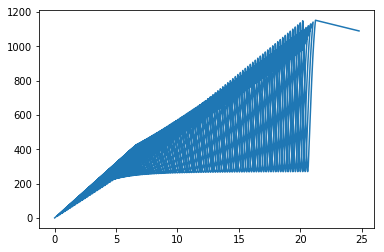

In [486]:
plt.plot(z[:,0],z[:,1])

In [ ]:
# print "Candidate links"
# for i in Transients.instances:
#     print websiteURL+str(i.id)

In [155]:
# print tgssscale
# print 'Fluxvary links'
# for i in FluxVar.instances:
#     print websiteURL+str(i.id)
#     print 'tgssflux: ' + str(tgss.pflux[i.entry])
# #     print tgss.ra[i.entry]
# #     print tgss.dec[i.entry]
# #     print i.ra
# #     print i.dec

## VLSSr

In [156]:
# Probably need to pip install xlrd for excell support in pandas
vlssr = dl.ReadData('vlssr')
print vlssr.keys

*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']


In [157]:
CheckOutsideDatabase(vlssr,rcheck = 5,ycheck = 5,checklight = True, gamma = True,deruiter = False)

before:
30
after:
2 Interesting candidates
16 Flux Varying candidates


# Print the same position Fluxvariating sources

In [158]:
for i in FluxVar.instances:
    
    print "Data compared to " + i.database.name
    print websiteURL+str(i.id)
    print 'bananaflux: ' + str(i.pflux*i.scale)
    print i.database.name+'flux: ' + str(i.database.pflux[i.entry])
    print "------------------------"
        
#     if i.database == 'vssr':
        
#         print 'bananaflux: ' + str(i.pflux * vlssrscale)
#         print 'vlssrflux: ' + str(vssr.pflux[i.entry])
#         print "########################"
#     print vssr.ra[i.entry]
#     print vssr.dec[i.entry]
#     print i.ra
#     print i.dec

Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2940
bananaflux: 4.92554256055319
vlssrflux: 4.409
------------------------
Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2606
bananaflux: 10.031228035238712
vlssrflux: 9.248
------------------------
Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3114
bananaflux: 2.0077601525553948
vlssrflux: 2.586
------------------------
Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3025
bananaflux: 1.8388427290056655
vlssrflux: 4.146
------------------------
Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/2630
bananaflux: 1.4386437336684124
vlssrflux: 0.408
------------------------
Data compared to vlssr
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/3112
bananaflux: 1.3421866140363632
vlssrflux: 0.411
-------

# Print the Position variating sources in Latex ready format

In [ ]:


print "\\begin{longtable}{c|c|c|c|c|c} \n\
\\toprule \nDatabase & Id & Ra & Dec & Link & y/n  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nDatabase & Id & Ra & Dec & Link & y/n  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with different databases for the 10 min interval data} \n\\endlastfoot"
lastname = None
for i in PosVar.instances:
    if i.database.name != lastname and lastname:
        print "\\hline"
    print i.database.name +" "+ "&"+ " "+ str(i.id) + " " + "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %(i.dec) +\
    " " + "&" + " " +latexURL +str(i.id)+"}" +" " + '&' + "  "+"\\" + "\\"
    
    lastname = i.database.name

print "\\end{longtable}"

In [ ]:
samesieslist = []
for i in range(len(PosVar.instances)):
    samesie = False
    for j in range(len(samesieslist)):
        if PosVar.instances[i].id == samesieslist[j][0]:
            samesieslist[j][1] = samesieslist[j][1] + " \& " + PosVar.instances[i].database.name
            samesie = True
    if not samesie:
        samesieslist.append([PosVar.instances[i].id,PosVar.instances[i].database.name,PosVar.instances[i]])
    
samesieslist = sorted(samesieslist, key=itemgetter(1))

print "\\begin{longtable}{c|c|c|c|c|c} \n\
\\toprule \nDatabase & Id & Ra & Dec & Link & y/n  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nDatabase & Id & Ra & Dec & Link & y/n  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with different databases for the 10 min interval data} \n\\endlastfoot"
lastname = None
for i in samesieslist:
    if i[1] != lastname and lastname:
        print "\\hline"
    print i[1] +" "+ "&"+ " "+ str(i[0]) + " " + "&"+ " " + '%0.3f' %i[2].ra + " " + "&"+ " "+ "%0.3f" %(i[2].dec) +\
    " " + "&" + " " +latexURL +str(i[0])+"}" +" " + '&' + "  "+"\\" + "\\"
    
    lastname = i[1]

print "\\end{longtable}"

In [ ]:
for i in range(len(Transients.instances)):
    if Transients.instances[i].id == 3324:
        print i

In [ ]:
r = CompareFluxes(vars(Transients.instances[7]),np.array(lightcata),np.array(lightecata))

In [ ]:
for j in range(len(lightcata)):
    if 0.594<=lightcata[j]<=0.7143 :
        print j

for i in range(len(r)):
    if r[i] <=1:
        print r[i]
print 'yoloswag'
print r[103]
print r[225]
print r[601]

In [ ]:
print idcata[0]

Delete double entries in transient list

Delete candidates that have an euclidean distance measure of 0.04 or less with the rest of the sources